# Semantic Kernel: Overview 

## AI Orchestration Framework for Building Applications

---

Semantic Kernel is an **open-source SDK** that lets you easily combine conventional programming languages with LLMs, AI "prompts" with templating, chaining, and planning capabilities.

#### Key Benefits:
- **Modular Architecture**: Plugin-based system for extensibility
- **Language Agnostic**: Available in C#, Python, and Java
- **Multi-Model Support**: Works with OpenAI, Azure OpenAI, Hugging Face, and more
- **Enterprise Ready**: Built for production scenarios with robust error handling

# Semantic Kernel

#### Serves as a middleware that bridge AI capabilities with traditional code, enabling developers to create intelligent applications that combine the power of Large Language Models with conventional programming logic.

## Core Architecture Principles

- **Modular Design**: Component-based architecture for flexibility
- **Extensible Framework**: Easy to add new capabilities via plugins
- **Multi-Service Integration**: Works with various AI providers
- **Async-First**: Built for high-performance, concurrent operations

## Some Use Cases

| Use Case | Description | Example |
|----------|-------------|---------|
| **Conversational AI** | Chatbots and virtual assistants | Customer service bots |
| **Content Generation** | Automated content creation | Blog posts, emails |
| **Data Analysis** | AI-powered data insights | Business intelligence |
| **Workflow Automation** | Intelligent process automation | Document processing |




## Ecosystem Integration

```mermaid
graph TD
    A[Your Application] --> B[Semantic Kernel]
    B --> C[Azure OpenAI]
    B --> D[AI Services]
    B --> E[Custom Models]
    B --> F[Plugins & Functions]
    B --> G[Memory Systems]
```
The Mermaid graph above illustrates how **Semantic Kernel acts as a central orchestration layer** that connects your application with various AI services and capabilities.

![Screenshot 2025-07-19 100551.png](<attachment:Screenshot 2025-07-19 100551.png>)

*Figure: Semantic Kernel ecosystem integration showing the relationship between your application, the kernel, and various AI services and capabilities.*

### Sample Information Flow

```
1. User Request → Application
2. Application → Semantic Kernel.invoke()
3. Kernel → Loads relevant plugins, chat_history, prompt_files
4. Kernel → Calls appropriate AI service (Azure OpenAI, Native Plugins, MCP)
5. AI Service → Returns response
6. Kernel → Processes through plugins if needed
7. Kernel → Updates memory systems
8. Application ← Formatted response
9. User ← Application
```

### Example

```
User Request: "I want a spicy vegetarian burger"
                                    ⬇
┌─────────────────────────────────────────────────────────────┐
│                    Semantic Kernel                          │
├─────────────────────────────────────────────────────────────┤
│ Context: "User is vegetarian, likes spicy food"             │
│ Menu Plugin: Filter vegetarian + spicy                      │
│ Brand Plugin: Apply Contoso (Casual & Friendly) personality │
│ Azure OpenAI: Generate personalized recommendation          │
└─────────────────────────────────────────────────────────────┘
                                    ⬇
Response: "Perfect! Our Spicy Black Bean Burger is amazing! 
It has jalapeños, and our signature hot sauce. 
Most customers say it's the perfect level of spice! 
Do you want a sesame or pretzel buns?"
```
The Semantic Kernel enables building **sophisticated, scalable AI applications** while maintaining **clean architecture** and **operational flexibility**!

### The Kernel

The **Kernel** is the central component of the Semantic Kernel. It acts as a dependency injection container that manages all of the services and plugins needed to run AI application.

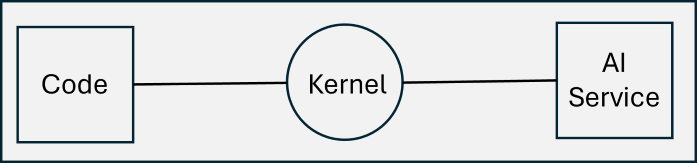
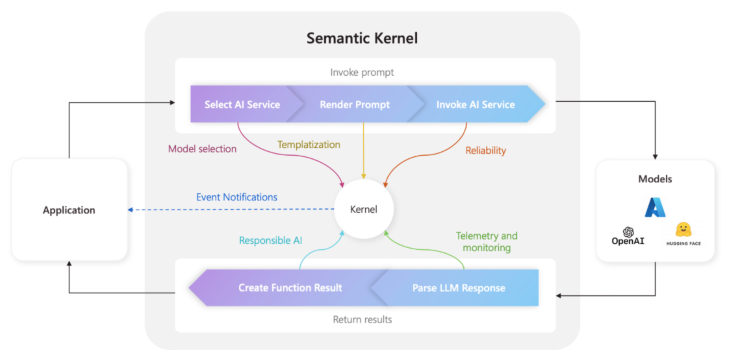

The **Kernel** is the main orchestrator responsible for the core functionality of Semantic Kernel

1. **Service Management**: Manages AI services (Azure OpenAI, OpenAI, etc.)
2. **Plugin Registry**: Registers and manages all available plugins and functions
3. **Prompt Processing**: Handles prompt template parsing and execution
4. **Function Invocation**: Orchestrates calls between plugins and AI services
5. **Memory Management**: Manages conversation history and context
6. **Error Handling**: Provides robust error handling and recovery



## Plugins

Plugins are the **core extensibility mechanism** of Semantic Kernel, it allows the integration of custom functions and tools with LLMs.

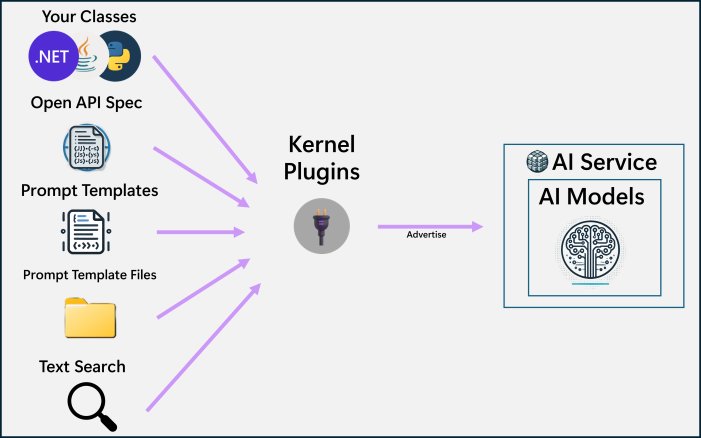

### Plugin Types

- **Native Plugins**: Custom Python classes with `@kernel_function`
- **OpenAI Configuration**: ChatGPT-compatible function definitions e.g. Standard AI tools 
- **MCP**: Model Context Protocol plugins for external integrations such as database connections, APIs:
    - **Stdio-based MCP Server**: name, description, command, arg, env access token
    - **SSE-based MCP Server**: name, description, url

### Key Benefits

- **Modular Design**: Each plugin encapsulates related functionality
- **Reusability**: Share plugins across different applications
- **Separation of Concerns**: Clear boundaries between different features
- **Extensibility**: Easy to add new capabilities without changing core code

### Kernel Functions

Functions decorated with `@kernel_function` within a Plugin are discovered and managed by the Kernel automatically

**Attributes**
- Decorated with `@kernel_function`
- Function descriptions and parameters
- Can be invoke by AI model during execution
- Integration with prompt templates and registering template as kernel function
- Stateless operations
- Support both sync and async operations

**Creating a Native Plugin**

In [1]:
import os
import json
import asyncio
from pathlib import Path
from typing import Dict, Optional, List
from dataclasses import dataclass
from dotenv import load_dotenv

from semantic_kernel import Kernel
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion
from semantic_kernel.functions.kernel_function_decorator import kernel_function
from semantic_kernel.functions.kernel_arguments import KernelArguments
from semantic_kernel.prompt_template import PromptTemplateConfig

load_dotenv()

@dataclass
class Message:
    role: str  # 'user', 'assistant', 'system'
    content: str

class BrandPersonalityPlugin:
    def __init__(self, kernel: Kernel, brand_name: Optional[str] = None):
        self.kernel = kernel
        self._load_brand_configs()
        self.current_brand = brand_name if brand_name in self.brand_configs else None

    def _load_brand_configs(self):
        config_path = Path.cwd().joinpath("brand_configs.json")
        try:
            with open(config_path, "r") as f:
                self.brand_configs = json.load(f)
        except Exception as e:
            print(f"Error loading brand configs: {e}")
            self.brand_configs = {}

    def set_brand(self, brand_name: str) -> bool:
        if brand_name in self.brand_configs:
            self.current_brand = brand_name
            return True
        return False   
     
    @kernel_function(description="Get brand personality instructions", name="get_brand_instructions")
    def get_brand_instructions(self, brand_name: Optional[str] = None) -> str:
        brand_name = brand_name or self.current_brand
        #brand = self.brand_configs.get(brand_name, {})
        
        if not brand_name:
            return "No brand personality selected."
            
        brand = self.brand_configs.get(brand_name, {})
        if not brand:
            return f"Brand '{brand_name}' not found."
        
        return f"""BRAND PERSONALITY: {brand['name']}.

                TONE AND STYLE:
                - Tone: {brand['tone']}
                - Style: {brand['style']}

                BRAND VOICE GUIDELINES:
                1. Key phrases to naturally incorporate: {', '.join(brand['key_phrases'])}

                2. Core brand values to embody: {', '.join(brand['values'])}

                Remember to maintain this brand voice consistently throughout the conversation while remaining helpful and natural."""
    def get_brand_name(self) -> str:
        if not self.current_brand:
            return "Restaurant"
        brand = self.brand_configs.get(self.current_brand, {})
        return brand.get('name', self.current_brand)

**Creating a Kernel and Registring a Plugin**

In [2]:
class ConversationFlow: # Base class for conversation flows
    def __init__(self, endpoint: str, api_key: str, deployment_name: str, brand_name: Optional[str] = None):
        self.endpoint = endpoint
        self.api_key = api_key
        self.deployment_name = deployment_name
        self.conversation_history: List[Message] = []
        
        self.kernel = Kernel()
        
        self.chat_service = AzureChatCompletion(
            deployment_name=deployment_name,
            endpoint=endpoint,
            api_key=api_key,
            service_id="azure_chat_completion"  
        )
        self.kernel.add_service(self.chat_service)

        # Add brand plugin
        self.brand_plugin = BrandPersonalityPlugin(self.kernel, brand_name)
        self.kernel.add_plugin(self.brand_plugin, "brand")
    
        self.setup_conversation_function()

    def setup_conversation_function(self):
        prompt_path = Path.cwd().joinpath("prompts/assistant_SK.prompty") # Loading prompt template
        
        try:
            with open(prompt_path, "r", encoding="utf-8") as f:
                template_content = f.read()
        except Exception as e:
            print(f"Warning: Could not load preamble template: {e}")

        # Create and register the prompt template as a plungin function
        prompt_config = PromptTemplateConfig(
            template=template_content,
            description="Brand-aware conversation",
            name="brand_conversation"
        )

        self.kernel.add_function(
            plugin_name="conversation",
            function_name="chat_with_brand",
            prompt_template_config=prompt_config
        )

    def format_chat_history(self) -> str:
        if not self.conversation_history:
            return "No previous conversation."
        
        formatted = []
        for msg in self.conversation_history[-10:]:  # Last 10 messages
            formatted.append(f"{msg.role}: {msg.content}")
        
        return "\n".join(formatted)

    async def process_user_input(self, user_input: str) -> str:
        try:
            self.conversation_history.append(Message(role="user", content=user_input))
            
            # arguments for the conversation function
            arguments = KernelArguments(
                brand_name=self.brand_plugin.get_brand_name(),
                brand_personality=self.brand_plugin.get_brand_instructions(),
                chat_history=self.format_chat_history(),
                user_input=user_input
            )
            
            result = await self.kernel.invoke(
                plugin_name="conversation",
                function_name="chat_with_brand",
                arguments=arguments
            )
            
            response = str(result)
            
            self.conversation_history.append(Message(role="assistant", content=response))
            
            return response
            
        except Exception as e:
            error_msg = f"error: {str(e)}"
            self.conversation_history.append(Message(role="assistant", content=error_msg))
            return error_msg

In [3]:
async def test_conversation():
    endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
    api_key = os.getenv("AZURE_OPENAI_API_KEY")
    deployment_name = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")
    brand_name = os.getenv("BRAND_NAME")
    
    if not endpoint or not api_key or not deployment_name:
        raise ValueError("Missing required environment variables: AZURE_OPENAI_ENDPOINT, AZURE_OPENAI_API_KEY, AZURE_OPENAI_DEPLOYMENT_NAME")
    
    flow = ConversationFlow(
        endpoint=endpoint,
        api_key=api_key,
        deployment_name=deployment_name,
        brand_name=brand_name
    )

    inputs = [
        "Hello!",
        "What's on the menu?",
        "What do you recommend for dnner of 5 including 2 toddlers with a vegetarian option?"
    ]

    for input_text in inputs:
        print(f"User: {input_text}")
        response = await flow.process_user_input(input_text)
        print(f"Assistant: {response}")
        print("-" * 50)
    return flow

In [4]:
import asyncio
await test_conversation()

User: Hello!
Assistant: Hello, welcome to P.F. Chang’s! 🌸  

How can I assist you with your dining experience today? Whether you're looking to explore our wok-fired selections, bold flavors, or have questions about the menu, I’m here to help craft your perfect order. Let’s get started!
--------------------------------------------------
User: What's on the menu?
Assistant: Certainly! Here's a glimpse of the P.F. Chang’s menu, crafted with care and full of bold, Asian-inspired flavors:  

### **Appetizers**  
- **Chang’s Lettuce Wraps**: A signature classic with wok-seared chicken or vegetarian options, paired with crisp lettuce cups.  
- **Dynamite Shrimp**: Crispy shrimp tossed in spicy Sriracha aioli, perfectly balanced and flavorful.  
- **Crispy Green Beans**: Tempura-battered green beans served with tangy dipping sauce.  

### **Entrees**  
- **Mongolian Beef**: Tender wok-fired beef with garlic and green onion, served with sweet soy glaze.  
- **Kung Pao Chicken**: Spicy stir-frie

**Resources & Links**
- [Microsoft Semantic Kernel GitHub](https://github.com/microsoft/semantic-kernel)
- [Official Semantic Kernel Documentation](https://learn.microsoft.com/semantic-kernel/)
- [Learning Path: Build AI solutions with Semantic Kernel](https://learn.microsoft.com/training/)
- [Blog: Semantic Kernel Updates](https://devblogs.microsoft.com/semantic-kernel/)